In [2]:
import os
import uuid
import yaml

import numpy as np
#import tensorflow as tf
import random
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#Data Generation

m = 3000

#======= BETA =======#
datarray = np.random.beta(0.5,0.5, m).astype(np.float32)

#======= NORMAL =======#
#datarray = np.random.normal(10,1, m).astype(np.float32)

#======= MULTINORMAL =======#
#cluster1 = np.random.normal(0,1, size=[2*m//3,1])
#cluster2 = np.random.normal(5,1, size=[m//3,1])
#datarray = np.concatenate((cluster1,cluster2))


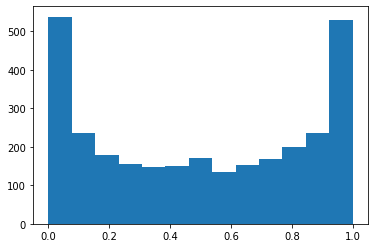

In [4]:
plt.hist(datarray, bins='auto')
plt.show()

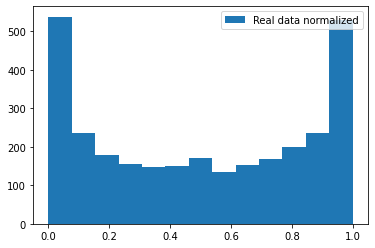

In [5]:
#Normalized Data visualization

def MinMaxN(X):
    return (X-np.min(X))/(np.max(X)-np.min(X) + 1e-8)

plt.hist(MinMaxN(datarray), bins='auto', label='Real data normalized')
plt.legend(loc='upper right')
plt.show()

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

In [23]:
X_dim = 1 #real sample size
z_dim = 30 #noise sample size (generator input)
h_dim = 100 #hidden layers size
h1_dim = 100
#h2_dim = 50
#h3_dim = 20
#h4_dim = 10

#----# INITIALITE PARAMETERS #----#

#X = tf.placeholder(tf.float32, shape=[X_dim,1])
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h1_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h1_dim]))

D_W2 = tf.Variable(xavier_init([h1_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

#D_W2 = tf.Variable(xavier_init([h1_dim, h2_dim]))
#D_b2 = tf.Variable(tf.zeros(shape=[h2_dim]))

#D_W3 = tf.Variable(xavier_init([h2_dim, h3_dim]))
#D_b3 = tf.Variable(tf.zeros(shape=[h3_dim]))

#D_W4 = tf.Variable(xavier_init([h3_dim, h4_dim]))
#D_b4 = tf.Variable(tf.zeros(shape=[h4_dim]))

#D_W5 = tf.Variable(xavier_init([h4_dim, 1]))
#D_b5 = tf.Variable(tf.zeros(shape=[1]))

#theta_D = [D_W1, D_W2, D_W3, D_W4, D_W5, D_b1, D_b2, D_b3, D_b4, D_b5]


z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h1_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h1_dim]))

G_W2 = tf.Variable(xavier_init([h1_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

#G_W2 = tf.Variable(xavier_init([h1_dim, h2_dim]))
#G_b2 = tf.Variable(tf.zeros(shape=[h2_dim]))

#G_W3 = tf.Variable(xavier_init([h2_dim, X_dim]))
#G_b3 = tf.Variable(tf.zeros(shape=[X_dim]))

#theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [8]:
def sample_z(m, n):
    #return np.random.normal(0., 1., size=[m, n])
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    #G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    #G_prob = tf.matmul(G_h1, G_W2) + G_b2
    #G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3)
    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    #D_h2 = tf.nn.relu(tf.matmul(D_h1,D_W2) + D_b2 )
    #D_h3 = tf.nn.relu(tf.matmul(D_h2,D_W3) + D_b3 )
    #D_h4 = tf.nn.sigmoid(tf.matmul(D_h3,D_W4) + D_b4 )
    out = tf.matmul(D_h1, D_W2) + D_b2 
    return out

In [9]:
def preprocess_data(x, batch_size):
     
    
    x_train = np.reshape(x, (len(x),))
    x_train = MinMaxN(x_train)

    # limit the data to full batches only
    num_batches = x_train.shape[0] // batch_size
    x_train = x_train[: num_batches * batch_size]
    #x_train = MinMaxN(x_train)

    # normalise the data to the range [-1,1] = [a,b]
    # X' = a + (b-a)(X-Xmin)/(Xmax-Xmin)
    #x_train = -1+2*(x_train-x_train.min())/(x_train.max()-x_train.min())

    # shuffle the data
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    return x_train, num_batches


In [10]:
def shuffle_data(x_train):
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    return x_train

In [27]:
lr = 1e-3
c_clip = 0.01

G_sample = generator(z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=lr)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=theta_G))

clip_D = [p.assign(tf.clip_by_value(p, -c_clip, c_clip)) for p in theta_D]

sess = tf.Session()
sess.run(tf.initialize_all_variables())

Iter: 0; D loss: -2.474e-05; G_loss: -0.0003163


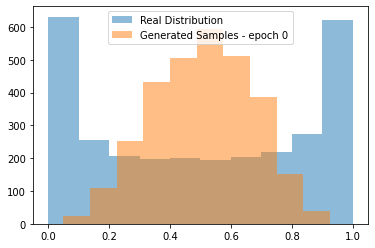

Iter: 100; D loss: 0.000145; G_loss: 0.0002525


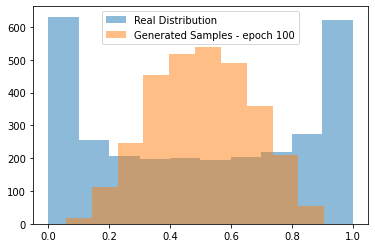

Iter: 200; D loss: 0.0002249; G_loss: 0.0007714


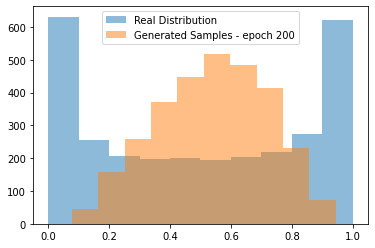

Iter: 300; D loss: 0.0001614; G_loss: 0.0009833


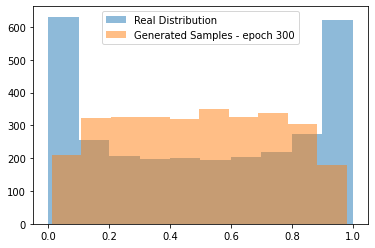

Iter: 400; D loss: 5.075e-05; G_loss: -5.713e-06


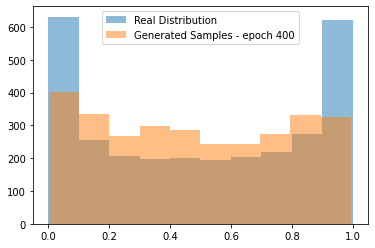

Iter: 500; D loss: 1.864e-05; G_loss: -1.135e-05


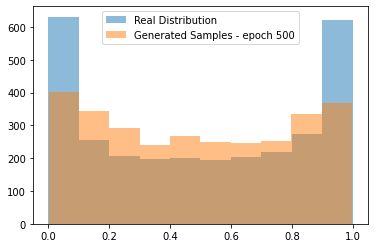

Iter: 600; D loss: -5.174e-06; G_loss: 0.0001732


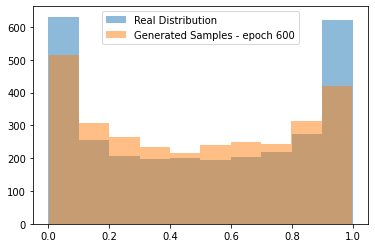

Iter: 700; D loss: 3.192e-07; G_loss: -0.0003341


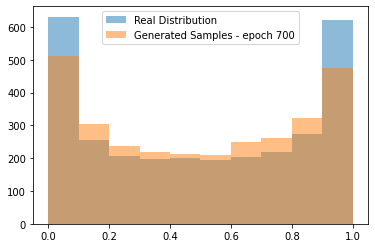

Iter: 800; D loss: 2.354e-07; G_loss: -0.0002241


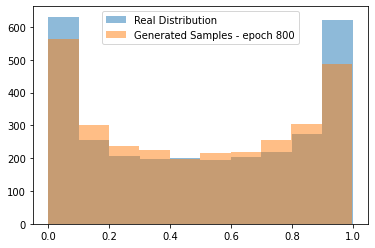

Iter: 900; D loss: 2.433e-07; G_loss: -4.938e-05


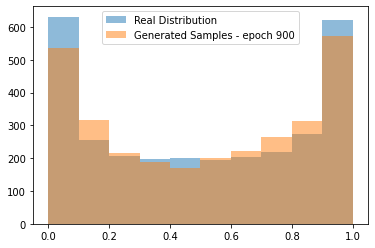

Iter: 1000; D loss: -1.878e-10; G_loss: 4.99e-07


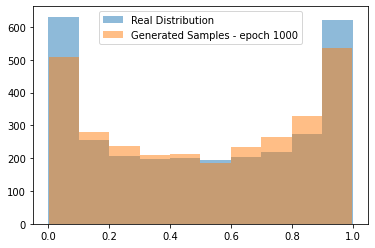

Iter: 1100; D loss: 1.946e-07; G_loss: -2.626e-05


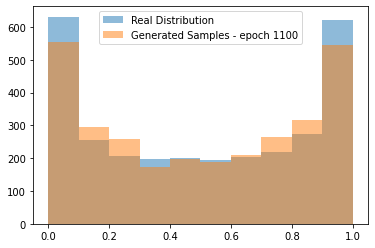

Iter: 1200; D loss: 3.553e-15; G_loss: -6.38e-09


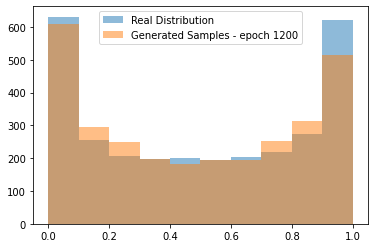

Iter: 1300; D loss: 0.0; G_loss: -0.0


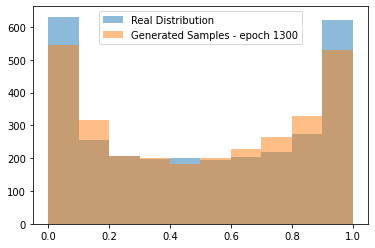

Iter: 1400; D loss: 0.0; G_loss: -0.0


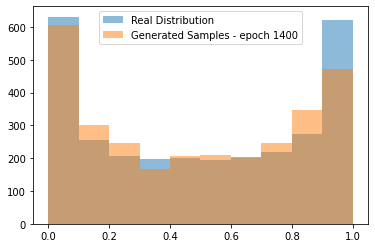

Iter: 1500; D loss: 0.0; G_loss: -0.0


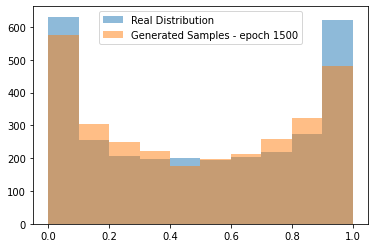

Iter: 1600; D loss: 0.0; G_loss: -0.0


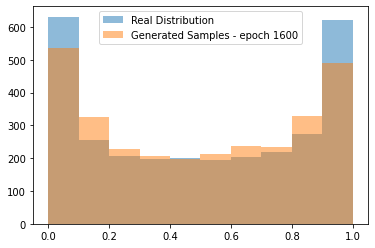

Iter: 1700; D loss: 0.0; G_loss: -0.0


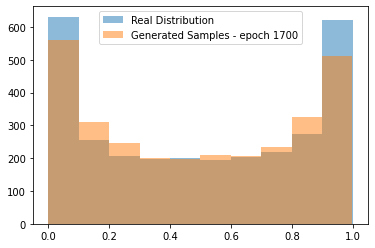

Iter: 1800; D loss: 0.0; G_loss: -0.0


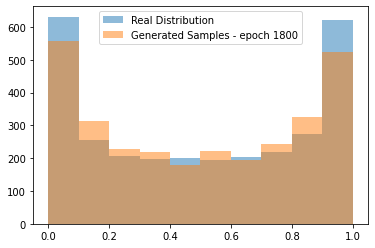

Iter: 1900; D loss: 0.0; G_loss: -0.0


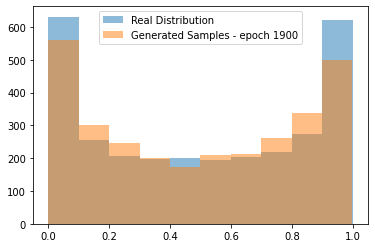

In [28]:

loss_batch = []
n_epochs = 2000
n_critic = 5
mb_size = 100

J_Ds = []  # stores the disciminator losses
J_Gs = []  # stores the generator losses
EM_dist = []

#preprocess input
x_train, num_batches = preprocess_data(datarray, mb_size)

for epoch in range(n_epochs):
    
    if epoch%(num_batches//n_critic)==0:
        x_train = shuffle_data(x_train)
        
    for n in range(n_critic):
        i = n + (epoch%(num_batches//n_critic))*n_critic
        X_mb = x_train[i * mb_size: (i + 1) * mb_size]
        #rand_index = np.random.choice(m, size = mb_size, replace = False)
        #X_mb = datarray[rand_index]
        X_mb = np.array(X_mb).reshape(mb_size,-1)
        #X_mb, _ = dataset.train.next_batch(mb_size)
        
        _, D_loss_curr, _ = sess.run(
            [D_solver, D_loss, clip_D],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)}
        )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )
    
    #J_Ds.append(D_loss_curr)
    #J_Gs.append(G_loss_curr)
    

    
    if epoch % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(epoch, D_loss_curr, G_loss_curr))
        
        samples = sess.run(G_sample, feed_dict={z: sample_z(len(x_train), z_dim)})

        plt.hist(datarray, alpha = 0.5, label = 'Real Distribution')
        plt.hist(samples, alpha = 0.5, label = 'Generated Samples - epoch ' + str(epoch) )
        plt.legend()
        plt.show()
        
        EM_dist.append(wasserstein_distance(x_train, np.reshape(samples, x_train.shape)))
        J_Ds.append(D_loss_curr)
        J_Gs.append(G_loss_curr)
    

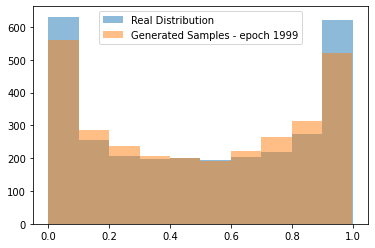

In [29]:
samples = sess.run(G_sample, feed_dict={z: sample_z(len(x_train), z_dim)})

plt.hist(datarray, alpha = 0.5, label = 'Real Distribution')
plt.hist(samples, alpha = 0.5, label = 'Generated Samples - epoch ' + str(epoch) )
plt.legend()
plt.show()

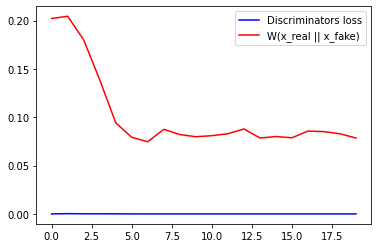

In [17]:
plt.plot(J_Ds, 'b', label='Discriminators loss')
plt.plot(EM_dist, 'r', label = 'W(x_real || x_fake)')
#plt.plot(J_Gs[0:600], 'r', label = 'Generators loss')
plt.legend()
plt.show()

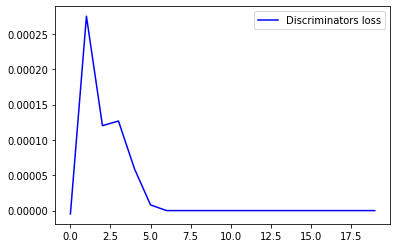

In [18]:
plt.plot(J_Ds, 'b', label='Discriminators loss')
#plt.plot(EM_dist, 'r', label = 'W(x_real || x_fake)')
#plt.plot(J_Gs, 'r', label = 'Generators loss')
plt.legend()
plt.show()

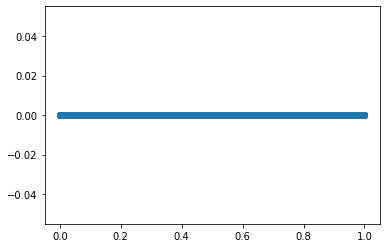

In [36]:
inp = np.random.uniform(0., 1., size=[m, 1])
plot_D = sess.run(D_real, feed_dict={X: inp})
plt.plot(inp, plot_D, 'o')

In [93]:
sess.run(D_real, feed_dict={X: np.random.uniform(0., 1., size=[m, 1])})

array([[0.000000e+00],
       [7.298624e-05],
       [0.000000e+00],
       ...,
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00]], dtype=float32)

In [ ]:
obje = np.arange(0.,1.,0.01)
X = np.reshape(x,(len(x),1))
plt.plot(x, forward_discriminator(X, W_d, b_d)[-1][-1])

In [72]:
def maxi (seq):
    sup = seq[0]
    for i in range(len(seq)):
        if seq[i]  >= sup:
            sup = seq[i]
            index = i
    return sup, index

def minim_k(k, seq):
    
    out = [seq[0]]
    for i in seq[1:]:
        if len(out) < k and i not in set(out):
            out.append(i)
        else:
            sup, index = maxi(out)
            if i <= sup and i not in set(out):
                out[index] = i
    
    if len(set(out))!= k:
        out = 'Null'
        
    return out

In [78]:
k = int(input('K:'))
seq = input('Sequence (in the format 1,2,3,...):')
seq = [int(i) for i in seq.split(',')]
minim_k(k,seq)

K:2
Sequence (in the format 1,2,3,...):0,5,2,2


[0, 2]

In [23]:
def sort(l):
    out = [l[0]]
    for i in l[1:]:
        j = 0
        while j < len(out) and i > out[j]:
            j+=1
        out.insert(j, i)
    return out

In [37]:
sort([2,3,3,3,5,2,2,4,6])

[2, 2, 2, 3, 3, 3, 4, 5, 6]

In [48]:
def minim_k2(seq, k):
    seq = sort(seq)
    if len(set(seq)) < k:
        out = 'Null'
    else:
        count = 1
        i = 0
        j = seq[0]
        while count < k:
            i+=1
            if seq[i] > j:
                count += 1
                j = seq[i]
        out = j
    return out           
        

In [49]:
minim_k2([2,3,3,3,5,4,5,2,2,4,6],3)

4

In [55]:
def list2set(l):
    out = [l[0]]
    for i in l[1:]:
        if i not in out:
            out.append(i)
    return out

In [56]:
list2set([2,3,3,3,5,4,5,2,2,4,6])

[2, 3, 5, 4, 6]

In [67]:
def minim_k3(seq,k):
    seq = sort(list2set(seq))
    if len(seq) < k:
        out = 'Null'
    else:
        out = seq[k-1]
    return out

In [68]:
minim_k3([2,3,3,3],3)

'Null'

In [75]:
def evenQ(n):
    return n%2 == 0

In [100]:
def EvenOdd(seq):
    out = str(seq[0])
    for i in range(1,len(seq)):
        if evenQ(seq[i-1]+seq[i]):
            out += str(seq[i]%2 * '-' + abs(seq[i]%2-1) * '*' )
        out += str(seq[i])
    return out

In [103]:
EvenOdd([2,1,4,6,2,6,7,5,7,5,6])

'214*6*2*67-5-7-56'

In [126]:
lol = '..#.'
[i for i in lol]

['.', '.', '#', '.']

In [108]:
[]+[[6]]+[[8]]

[[6], [8]]

In [113]:
lst=[0,0,0,0,1,0]
next(x for x in range(len(lst)) if lst[x] == 1)

4

In [115]:
5*True

5

In [116]:
lst.append(5*False)

In [117]:
lst

[0, 0, 0, 0, 1, 0, 0]

In [118]:
[1]+[1]

[1, 1]

In [120]:
next((0) if lst[0]==0)

SyntaxError: invalid syntax (<ipython-input-120-e992d2247b5a>, line 1)

In [121]:
lst.append((1,2))

In [122]:
lst

[0, 0, 0, 0, 1, 0, 0, (1, 2)]

In [123]:
a, b = (1,0)

In [124]:
a

1

In [129]:
for i in 'one':
    print('\n', i)


 o

 n

 e


In [130]:
'n' in 'one'

True

In [132]:
def checkNumb(s, n):
    result = True
    for i in n:
        result = result * (i in s)
    return result

In [136]:
checkNumb('aubsnno','one') == True

False

In [142]:
s = 'aeubsnno'

In [143]:
def removeNumb(n,s):
    for i in n:
        s.remove(i)
    return s

In [154]:
checkNumb('nine',['n','i','n','e'])

1

In [148]:
s = list('oeisowufxrzohgiettr')
numbs = []
while len(s) >= 3:
    if 'w' in s:
        s = removeNumb('two',s)
        numbs.append(2)
    if 'u' in s:
        s = removeNumb('four',s)
        numbs.append(4)
    if 'x' in s:
        s = removeNumb('six',s)
        numbs.append(6)
    if 'v' in s:
        s = removeNumb('seven',s)
        numbs.append(7)
    if 'g' in s:
        s = removeNumb('eight',s)
        numbs.append(8)
    if 'z' in s:
        s = removeNumb('zero',s)
        numbs.append(0)

In [149]:
numbs

[2, 4, 6, 8, 0]

In [156]:
cena = ['oeisowufxrzohgiettr']

In [159]:
def checkNumb(n, s):
    result = True
    if len(s)==0:
        result = False
    for i in n:
        result = result * (i in s)
    return result

def removeNumb(n,s):
    for i in n:
        s.remove(i)
    return s

def sort(l):
    out = [l[0]]
    for i in l[1:]:
        j = 0
        while j < len(out) and i > out[j]:
            j+=1
        out.insert(j, i)
    return out

for line in cena:
    s = list(line)
    numbs = []
    while 'w' in s or 'u' in s or 'x' in s or 'v' in s or 'g' in s or 'z' in s:
        if 'w' in s:
            s = removeNumb('two',s)
            numbs.append(2)
        if 'u' in s:
            s = removeNumb('four',s)
            numbs.append(4)
        if 'x' in s:
            s = removeNumb('six',s)
            numbs.append(6)
        if 'v' in s:
            s = removeNumb('seven',s)
            numbs.append(7)
        if 'g' in s:
            s = removeNumb('eight',s)
            numbs.append(8)
        if 'z' in s:
            s = removeNumb('zero',s)
            numbs.append(0)
    
    while 'o' in s or 't' in s or 'f' in s:
        if 'o' in s:
            s = removeNumb('one',s)
            numbs.append(1)
        if 't' in s:
            s = removeNumb('three',s)
            numbs.append(3)
        if 'f' in s:
            s = removeNumb('five',s)
            numbs.append(5)
    
    while checkNumb('nine', s):
        s = removeNumb('one',s)
        numbs.append(9)

In [163]:
out = ''
for i in sort(numbs):
    out += str(i)
out

'02468'